# Radial Gradients from MaNGA Data

This notebook will walk through how to plot a radial gradient for a single MaNGA galaxy, and also for a sample of galaxies. 

Hopefully. 

Code and comments by Emmy Wisz and Karen Masters. 



In [1]:
#First various import statements. 
#General imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as sci

#Marvin related stuff
import marvin
from marvin import config
#config.forceDbOff() #Sometimes this helps Marvin run for some reason. 
from marvin.tools.maps import Maps
import marvin.utils.plot.map as mapplot


/packages/python3.7.7/lib/python3.7/site-packages/sdss_marvin-2.7.1-py3.7.egg/marvin/core/exceptions.py:51: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  UserWarning)
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /homes/ewisz/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /homes/ewisz/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


First get the data for a single galaxy and plot an image of it. 

<WCSAxes:>

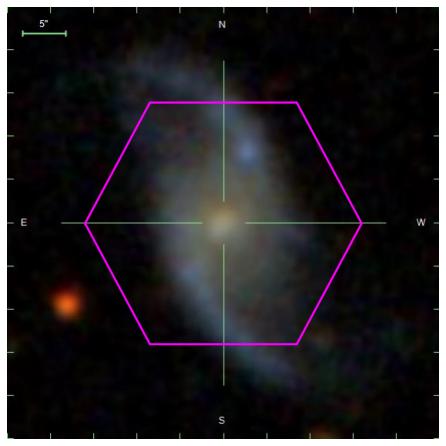

In [2]:
maps = Maps('12491-12704')
#maps = Maps('8483-3701')

image = Maps.getImage(maps)
image.plot()

Get a map and plot it. Here we pick the Halpha emission line map. 

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Emission line Gaussian flux: H-alpha 6564'}, xlabel='spaxel', ylabel='spaxel'>)

[WARNING]: Warning: converting a masked element to nan. (UserWarning)


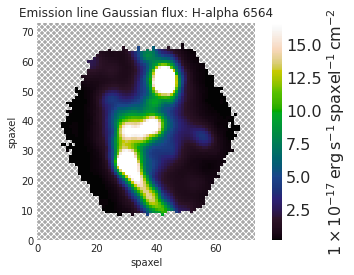

In [3]:
ha = maps.emline_gflux_ha_6564
ha.plot()


## Measure and Calculate Metallicity

You can plot radial gradients of all kinds of stuff using MaNGA data. The example we will use here is the gas phase metallicity from the Halpha and [NII] emission line maps. 

### Pettini & Pagel (2004) N2 metallicity calibration

Use Equation 1 from Pettini & Pagel (2004) for the N2 metallicity calibration:

12 + log(O/H) = 8.90 + 0.57 $\times$ log( $\frac{F([NII])}{F(H\alpha)}$ ).

Get [NII] 6585 and Halpha flux maps from the Marvin `Maps` object. Calculate the ratio. 

In [4]:
nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564

n2 = nii / ha

We can plot these maps individually to see what the data and map style look like:

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:title={'center':'Emission line Gaussian flux: NII 6585'}, xlabel='spaxel', ylabel='spaxel'>)

[WARNING]: Warning: converting a masked element to nan. (UserWarning)


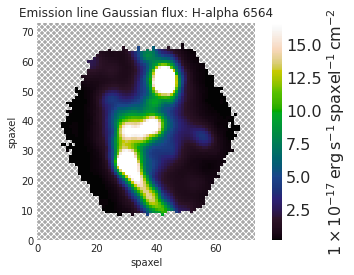

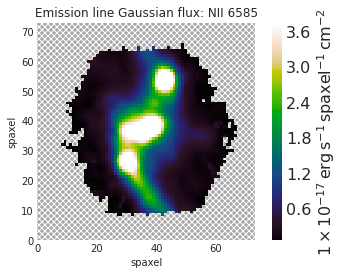

In [5]:
ha.plot()
nii.plot()

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


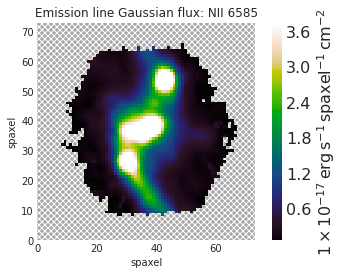

In [6]:
nii.plot()
nii_example_name = 'Plots/nii_example.pdf'
plt.savefig(nii_example_name, bbox_inches='tight')

Use the n2 ratio to calculate the metallicity and save the map values. Plot the metallicity map. 

[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


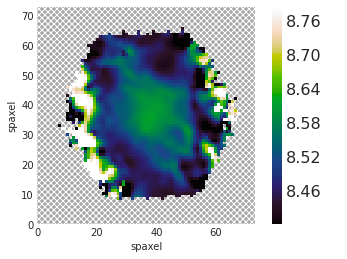

In [7]:
def metallicity(ratio):
    return 8.90 + 0.57 * np.log10(ratio)

metal = metallicity(n2)

metal.plot()
metallicity_example_name = 'Plots/metallicity_example.pdf'
plt.savefig(metallicity_example_name, bbox_inches='tight')

## Creating Masks

Masks are useful to select regions of the data for different science cases. 

For example, we can use the BPT diagnostic to pick out Halpha emission likely due to star formation, or we can remove low SNR spaxels. Use the n2 ratio to calculate the metallicity and save the map values. Plot the metallicity to see how the maps change.  

[WARNING]:  (MatplotlibDeprecationWarning)


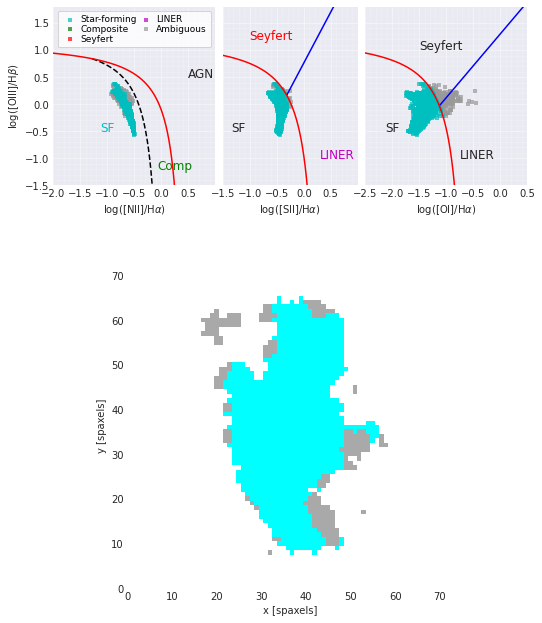

<Figure size 432x288 with 0 Axes>

In [8]:
#this will plot the BPT diagrams for the given galaxy 
masks, fig, axes = maps.get_bpt()

bpt_example_name = 'Plots/bpt_example.pdf'
plt.savefig(bpt_example_name, bbox_inches='tight')

In [9]:
#Set up various masks from BPT and snr.
sf = masks['sf']['global']
mask_non_sf = ~sf * n2.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = n2.pixmask.get_mask("UNRELIABLE")
high_snr = mapplot.mask_low_snr(value=ha.value, ivar=ha.ivar, snr_min=3)

In [10]:
#Combine to make a master mask
master_mask = mask_non_sf | mask_bad_data | high_snr

We can use the new master mask to plot the metallicity without all of the data that we have just deemed unwanted. 

[WARNING]: Warning: converting a masked element to nan. (UserWarning)
[WARNING]: Warning: converting a masked element to nan. (UserWarning)


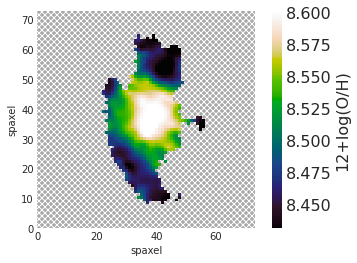

In [11]:
fig, ax = metal.plot(mask=master_mask, cblabel='12+log(O/H)')

masked_metal_example_name = 'Plots/masked_metal_example.pdf'
plt.savefig(masked_metal_example_name, bbox_inches='tight')

## Radius-Metallicity Plotting

We need to get the map for the radius in order to plot the metallicity gradient as a function of radius. Marvin has a couple of radius options, but here we will use the radius as a fraction of the effective radius. Keep in mind that these values already have deprojection accounted for.

It's really easy to make a scatter plot of all the spaxel metallicity and radius values. 

(0.0, 2.5)

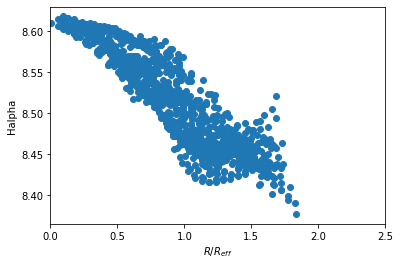

In [12]:
radius = maps.spx_ellcoo_r_re

plt.scatter(radius.value[master_mask==0],metal.value[master_mask==0])
plt.xlabel(r'$ R/R_{eff} $')
plt.ylabel('Halpha')
plt.xlim(0,2.5)

## Plotting Average as a Function of Radius

Now we want to find the binned average metallicity by radius for a galaxy. To do this, we will copy the code from the cell above and add a line using scipy's function `binned_statistic`. Here we will use a line plot instead of a scatter to look at the relation of the averages by radius. 

The documentation is here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html

Text(0, 0.5, 'Mean Metallicity')

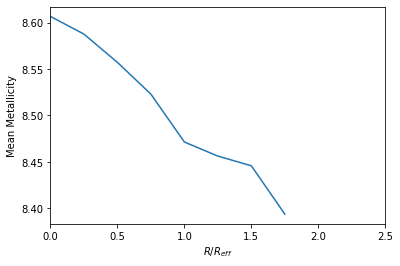

In [13]:
metal_mean,radius_mean,binnumber = sci.binned_statistic(radius.value[master_mask==0],metal.value[master_mask==0],bins=10, range=[0,2.5])


plt.plot(radius_mean[:-1], metal_mean)
plt.xlim(0,2.5)
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Mean Metallicity')
#     plt.legend()


Plot the scatter and the gradient together to double check that the code is doing what is wanted.

0.125


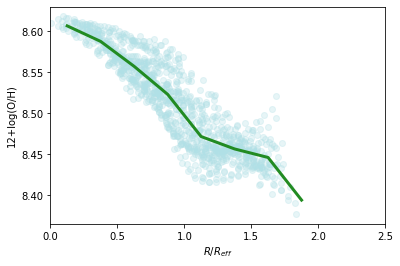

In [20]:
plt.scatter(radius.value[master_mask==0],metal.value[master_mask==0], alpha = 0.3, color = 'powderblue')
metal_mean,radius_mean,binnumber = sci.binned_statistic(radius.value[master_mask==0],metal.value[master_mask==0],bins=10, range=[0,2.5])

print((radius_mean[1] - radius_mean[0])/2)
plt.plot((radius_mean[:-1] + 0.125), metal_mean, color = 'forestgreen', linewidth = 3)
#careful!! size of bin hard coded
plt.xlim(0,2.5)
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('12+log(O/H)')
#     plt.legend()

metalgrad_example_name = 'Plots/metalgrad_example.pdf'
plt.savefig(metalgrad_example_name, bbox_inches='tight')

This looks pretty good so lets move on to plotting multiple galaxies.

# Multiple galaxy plot

To run this for multiple galaxies it would be useful to turn it into a function which returns the binned average values we want for a single galaxy. 

Right now this function freaks out if all spaxels get masked out, so that's an issue. 

[WARNING]: divide by zero encountered in power (RuntimeWarning)
[WARNING]: invalid value encountered in true_divide (RuntimeWarning)
[WARNING]: divide by zero encountered in log10 (RuntimeWarning)


Text(0, 0.5, 'Mean Metallicity')

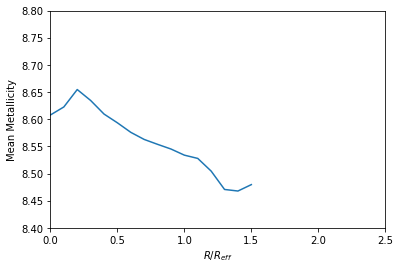

In [19]:
def metalgradient(galaxy):
   
    #Get data for galaxy
    maps = Maps(galaxy)
    nii = maps.emline_gflux_nii_6585
    ha = maps.emline_gflux_ha_6564
    radius = maps.spx_ellcoo_r_re
    
    #Metallicity calc
    n2 = nii / ha
    metal = 8.90 + 0.57 * np.log10(n2)
    
    #Masks
    masks = maps.get_bpt(return_figure=False, show_plot=False) #Version of BPT which only returns mask
    sf = masks['sf']['global']
    mask_non_sf = ~sf * n2.pixmask.labels_to_value('DONOTUSE')
    mask_bad_data = n2.pixmask.get_mask("UNRELIABLE")
    high_snr = mapplot.mask_low_snr(value=ha.value, ivar=ha.ivar, snr_min=3)
    master_mask = mask_non_sf | mask_bad_data | high_snr
    
    metal_mean,radius_mean,binnumber = sci.binned_statistic(radius.value[master_mask==0],metal.value[master_mask==0],bins=20,range=[0,2.0])
    
    return metal_mean,radius_mean


y,x=metalgradient('8998-12704')

plt.plot(x[:-1], y)
plt.xlim(0,2.5)
plt.ylim(8.4,8.8)
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Mean Metallicity')
#     plt.legend()

Successful 8998-12701
Successful 8998-12702
Successful 8998-12704
Successful 8998-12705
Successful 8483-3701
[]


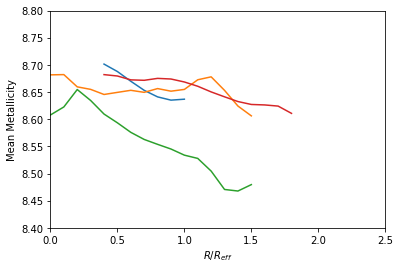

In [99]:
#Now how about running this on a list of MaNGA galaxies. We'll make it a short list to start with. 

#Plateifu_list = ['8998-12701','8998-12702','8998-12705']
Plateifu_list = ['8998-12701','8998-12702','8998-12704','8998-12705','8483-3701']

error_list = []
r_list = []
y_list = []

plt.plot()
plt.xlim(0,2.5)
plt.ylim(8.4,8.8)
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Mean Metallicity')

for plateifu in Plateifu_list:
    try :
        y,x=metalgradient(plateifu)
        plt.plot(x[:-1], y)    
        y_list.append(y)
        r_list.append(x[:-1]) #Fence post issue
        print('Successful', plateifu)
    except :
        error_list.append(plateifu)
        print('Problems with:')
    continue

print(error_list)

In [100]:
# This also outputs a list of all the values of averaged radii and metallicity. 
# It outputs a list of arrays, so we need to convert to a single array to do things. 

r=np.concatenate(r_list, axis=0)
y=np.concatenate(y_list, axis=0)

#Clean out nan values because they break the next step
r = r[np.logical_not(np.isnan(y))]
y = y[np.logical_not(np.isnan(y))]

print,y

(<function print>,
 array([8.70151679, 8.68782214, 8.66996589, 8.65324803, 8.64120453,
        8.63520446, 8.63694668, 8.68172646, 8.68217945, 8.659665  ,
        8.65502848, 8.64562702, 8.64949719, 8.65328988, 8.64955443,
        8.65648501, 8.6516949 , 8.65492535, 8.67268531, 8.67807913,
        8.65317488, 8.62434959, 8.60626888, 8.60795069, 8.62267997,
        8.65470279, 8.63461712, 8.60962378, 8.59349699, 8.575967  ,
        8.56289972, 8.55389657, 8.54527985, 8.53401123, 8.5280081 ,
        8.50467565, 8.47088998, 8.46802299, 8.479802  , 8.68215516,
        8.67961066, 8.67251632, 8.67171029, 8.6752385 , 8.67407614,
        8.6686201 , 8.66074691, 8.65033875, 8.64131586, 8.63263239,
        8.62725482, 8.62638524, 8.62426335, 8.61087823]))

Text(0, 0.5, 'Mean Metallicity')

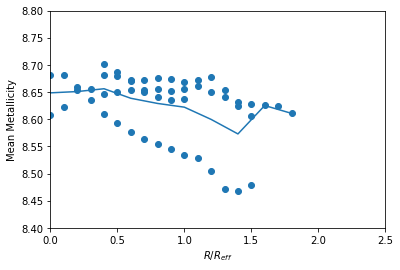

In [102]:
#Then this should work to make a single average plot for the sample of galaxies. 


plt.scatter(r,y) #Use this to check where the values are which are being averaged. May not always need it. 

meta_metal_mean,meta_radius_mean,binnumber = sci.binned_statistic(r,y,bins=10,range=(0,2.0))
plt.plot(meta_radius_mean[:-1], meta_metal_mean)

plt.xlim(0,2.5)
plt.ylim(8.4,8.8)
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Mean Metallicity')